<a href="https://colab.research.google.com/github/edgeofchaos42/ComplexityExplorer/blob/main/Session_17_Data_Collector_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1- Review lesson 16 and intro

Script Notes: 

In lesson 16 we completed the the trading algorithm; now we have a lot of agents doing a lots of things so now we want to leverage Mesa's data collector to capture all this information and see if our model matches the original and if it matches predicted results. THis will validate our model so in this session we will collect the data and then in the next session we will visualize it. 

*Review each class and model set up*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try: 
  import mesa
except: 
  !pip install mesa --quiet
  import mesa
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools


from statistics import mean
from scipy.stats import gmean



%matplotlib inline 

In [4]:
def get_distance(pos_1, pos_2):
    """Calculate Euclidean distance between two positions.
    Args:
        pos_1, pos_2: Coordinate tuples for both points.
    
    used in trader.move()
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def quick_mean(prices):
  if len(prices) == 0: return 0
  else: 
    return sum(prices)/len(prices)

In [5]:
class Sugar(mesa.Agent):
    """
    Sugar is a FSM that
    - contains an amount of sugar
    - grows 1 amount of sugar at each turn (rule G1).
    """
    
    
    def __init__(self, unique_id, model, pos, max_sugar): 
      super().__init__(unique_id, model) #part 3
      self.pos = pos
      self.amount = max_sugar
      self.max_sugar = max_sugar

    def step(self): 
      self.amount = min([self.max_sugar,self.amount+1])
      
      

In [6]:
class Spice(mesa.Agent):
    """
    Spice is a FSM that
    - contains an amount of spice
    - grows 1 amount of spice at each turn. (rule G1)
    """

    def __init__(self, unique_id, model, pos, max_spice): 
        super().__init__(unique_id, model) 
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self): #Part 1
      self.amount = min([self.max_spice,self.amount+1])
       

In [7]:
class Trader(mesa.Agent):
    """
    TraderAgent is a 
    - has a metabolism for sugar and spice
    - harvest and trades sugar and spice to survive and thrive
    """

    def __init__(self, unique_id, model,pos,moore=False, sugar=0, 
                 spice=0, metabolism_sugar=0, metabolism_spice=0,
                 vision=0): 
      super().__init__(unique_id, model)
      self.pos = pos 
      self.moore = False 
      self.sugar = sugar 
      self.spice = spice 
      self.metabolism_sugar=metabolism_sugar 
      self.metabolism_spice=metabolism_spice 
      self.vision = vision 
      self.prices = []
      self.trade_partners = []

  
    def get_sugar(self, pos): #part 2
      '''
      used in:
         get_sugar_amount()
         eat()

      '''
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell:
          if type(agent) is Sugar:
              return agent
      return None
    
    
    def get_sugar_amount(self, pos):
      '''
      used in move()
      '''
      
      sugar_patch = self.get_sugar(pos)
      if sugar_patch:
          return sugar_patch.amount
      return 0
    
    
    def get_spice(self, pos):
      '''
      used in get_spice_amount
      '''
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell:
          if type(agent) is Spice:
              return agent
      return None
        
    
    def get_spice_amount(self, pos):
        '''
        used in move()
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch: 
          return spice_patch.amount
        return 0
  
    def get_trader(self, pos):
      '''
      used in trade_with neighbors()
      '''
      this_cell =self.model.grid.get_cell_list_contents(pos)

      for agent in this_cell: 
        if isinstance(agent, Trader):
          return agent
    
    
    def is_occupied(self, pos): 
      '''
      Helper function for move()
      '''
      
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for a in this_cell:
          if isinstance(a, Trader) and a.pos != self.pos:
              return True
      return False
       
    def calculate_welfare(self, sugar, spice): #This will be built to be like the example later with none, but right now it wouldn't make any sense
      '''
      Helper function for:
      move()
      trade()

      '''

      #calculate total resources
      m_total = self.metabolism_sugar + self.metabolism_spice
      #Cobb-Douglas functional form
      return sugar** (self.metabolism_sugar/m_total) * spice ** (
          self.metabolism_spice/m_total)
      
    def is_starved(self): 
      '''
      helper function for maybe_die()
      '''

      return (self.sugar <= 0) or (self.spice <=0)

    def calculate_MRS(self): 
      '''
      used in trade()
      '''

      return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
      '''
      Helper function for maybe_sell_spice() which is called from trade()
      '''
      if price >= 1:
          sugar = 1
          spice = int(price)
      else:
          sugar = int(1 / price)
          spice = 1
      return sugar, spice

    def sell_spice(self, other, sugar, spice):
      '''
      used in maybe_sell_spice
      :param: Agent object
      :param: int sugar to be exchanged
      :param: int spice to be exchanged
      '''

      self.sugar += sugar
      other.sugar -= sugar
      self.spice -= spice
      other.spice += spice
  
    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
      '''
      helper function for trade()
      '''
      sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

      # Preparing the new sugar spice amount -- what if the exchange were to occur.
      self_sugar = self.sugar + sugar_exchanged
      other_sugar = other.sugar - sugar_exchanged
      self_spice = self.spice - spice_exchanged
      other_spice = other.spice + spice_exchanged

      #Double Check to see if agents have resources

      if (
          (self_sugar <=0)
       or (other_sugar <= 0)
       or (self_spice <= 0)
       or (other_spice <= 0)):
        return False

      #trade crtieria 1 are both agents better off?
      both_agents_better_off = (
          welfare_self < self.calculate_welfare(self_sugar, self_spice) and 
          (welfare_other < other.calculate_welfare(other_sugar, other_spice)))
      
      #trade criteria 2 is their mrs crossing
      mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

      if not (both_agents_better_off and mrs_not_crossing):
            return False

      #add sell spice
      self.sell_spice(other, sugar_exchanged, spice_exchanged)

      return True
       

    
    def trade(self, other):
      '''
      used in trade_with_neighbors()
      '''
      #Part 0
      #sanity check to verify code is working the way we think
      assert self.sugar > 0
      assert self.spice > 0
      assert other.sugar > 0 
      assert other.spice > 0 

      mrs_self = self.calculate_MRS()
      mrs_other = other.calculate_MRS()
      #part 1: 
      welfare_self = self.calculate_welfare(self.sugar, self.spice)
      welfare_other = other.calculate_welfare(other.sugar, other.spice)

      if math.isclose(mrs_self, mrs_other, rel_tol=1e-2): 
        return 

      price = math.sqrt(mrs_self*mrs_other)

      if mrs_self > mrs_other: 
        #self is a sugar buyer
        sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
        #part 2
        if not sold: 
          return
      else: 
        #self is a spice buyer
        sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
        if not sold: 
          return
      
      #part 3
      self.prices.append(price)
      if other.unique_id not in self.trade_partners: 
        self.trade_partners.append(other.unique_id)

      #continue trading
      self.trade(other)




    ###########################################################################
    #                                                                         #
    #                            MAIN FUNCTIONS                               #
    #                                                                         #
    ###########################################################################

    def move(self): 
           
      # 1. Get neighbors within vision

      neighbors = [i 
                   for i in self.model.grid.get_neighborhood(
                       self.pos, self.moore,True, self.vision
                       )
                   if not self.is_occupied(i)
      ]

      # 2. Find the patch which produce the maximum welfare. 

      welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos),
                self.spice + self.get_spice_amount(pos),
            )
            for pos in neighbors] #part 2

      #find the highest welfare in the cell 
      max_welfare = max(welfares)
      #get the index of maximal welfare cells
      candidate_indices = [i for i in range(len(welfares))
                             if math.isclose(welfares[i], max_welfare,
                                             rel_tol=1e-02)]
      #convert index to positions of those cells
      candidates = [neighbors[i] for i in candidate_indices]
     
      
      # 3. Find the nearest patch among the candidate.
      min_dist = min([get_distance(self.pos, pos) for pos in candidates])
      final_candidates = [pos for pos in candidates if math.isclose(get_distance(self.pos, pos),
                                                                   min_dist, rel_tol=1e-02)]
      self.random.shuffle(final_candidates)

      # 4. Move agent.
      self.model.grid.move_agent(self, final_candidates[0])



    def eat(self):
      #get sugar
      sugar_patch = self.get_sugar(self.pos)

      if sugar_patch:
        self.sugar = self.sugar - self.metabolism_sugar + sugar_patch.amount
        sugar_patch.amount = 0
        #print(self.sugar, sugar_patch.amount)
      
      #get_spice part 2
      spice_patch = self.get_spice(self.pos)
      #print(spice_patch)
      if spice_patch: 
        self.spice = self.spice - self.metabolism_spice + spice_patch.amount
        spice_patch.amount = 0
        #print(self.spice, spice_patch.amount)

    def maybe_die(self): 

      if self.is_starved(): 
        self.model.grid.remove_agent(self) 
        self.model.schedule.remove(self)
          
    def trade_with_neighbors(self):
      
      neighbor_agents =[self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
          self.pos, self.moore, False, radius=self.vision) if self.is_occupied(pos)]
        
      if len(neighbor_agents) == 0:
            #part 4
            return [], []
      
      for a in neighbor_agents: 
        if a: 
          self.trade(a)
      #
      prices = [p for p in self.prices if p ]
      trader_partners = [t for t in self.trade_partners if t]
      self.prices = []
      self.trade_partners = []
      #print(prices, trader_partners)
      return prices, trader_partners

## Add Data Collector

**Part 1**

------------

We add data collector to the model initialization. To start we will collect at the model level aggregate behavior with three pieces of data. How many agents are alive, what is the average trade price and what is the trade volume. We will do this to see how our model matches the results in Growing artificial societies. 


To initialize the data collected we need to do create self.datacollector and instnatiate mesa.DataCollector and then we create a dictionary of what we want to create, so 

First will be the number of traders - "Traders" with a lambda function calling the number of traders from mesa get agent count by type trader

Second we will do trade volume with a key called "Trade Volume and a lambda function that adds the length of an agents trade partners together. 

Third, we will do the price importing the geometric mean from scipystats we can collect that for each step 


We then add datacollector to the step function to collect this information at each step and then run the model 



In [14]:
class SugarscapeG1mt(mesa.Model):

  def __init__(self, width=50, height=50, initial_population=200,
               endowment_min =25, endowment_max =50, metabolism_min = 1,
                 metabolism_max = 5, vision_min = 1, vision_max =5): 
    
    self.width = width
    self.height = height
    self.initial_population =initial_population 
    self.endowment_min = endowment_min 
    self.endowment_max = endowment_max 
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max


    self.schedule = mesa.time.RandomActivationByType(self)
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)
    
    
    #####################################################################
    #####################################################################
    #

    #part 1
    self.datacollector = mesa.DataCollector(
        {"Trader": lambda m: m.schedule.get_type_count(Trader),
         "Trade volume": lambda m: sum(len(a.trade_partners)
         for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: gmean(list(itertools.chain.from_iterable([a.prices for a in m.schedule.agents_by_type[Trader].values()])))}
    )

    sugar_distribution = np.genfromtxt("/content/drive/MyDrive/sugar-map.txt") 
    spice_distribution = spice = np.flip(sugar_distribution,1)
    
    #ensure unique id
    agent_id = 0
    for _, x, y in self.grid.coord_iter(): 
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0: 
        sugar = Sugar(agent_id, self, (x,y),max_sugar)
        self.grid.place_agent(sugar, (x, y))
        #Place Agent
        self.schedule.add(sugar) 
        agent_id += 1

      max_spice = spice_distribution[x,y]
      if max_spice > 0: 
        spice = Spice(agent_id, self, (x,y), max_spice)
        self.grid.place_agent(spice,(x,y))
        self.schedule.add(spice)
        agent_id += 1
         
    
    for i in range(self.initial_population):
      #get agent position
      x = self.random.randrange(self.width) 
      y = self.random.randrange(self.height) 
      # See GAS page 108 for parameters initialization.
      # Each agent is endowed by a random amount of sugar and spice
      sugar = self.random.uniform(self.endowment_min, self.endowment_max+1) 
      spice = self.random.uniform(self.endowment_min, self.endowment_max+1) 
      #add metabolism also on page #108
      metabolism_sugar = self.random.uniform(self.metabolism_min, self.metabolism_max)
      metabolism_spice = self.random.uniform(self.metabolism_min, self.metabolism_max)
      #add vision
      vision =int(self.random.uniform(self.vision_min, self.vision_max))
      trader = Trader(
                agent_id,
                self,
                (x, y),
                False,
                sugar,
                spice,
                metabolism_sugar,
                metabolism_spice,
                vision,
            )
      self.grid.place_agent(trader, (x, y))
      self.schedule.add(trader)
      agent_id += 1
      
  def randomize_traders(self): 
    """
    Helper function for step()

    updates list of agents used in step function
    """
    
    Traders = self.schedule.agents_by_type[Trader].values()
    Trader_shuffle = list(Traders)
    self.random.shuffle(Trader_shuffle)

    return Trader_shuffle
  
  
  def step(self): 
    
    for sugar in self.schedule.agents_by_type[Sugar].values(): 
      sugar.step()
    
    for spice in self.schedule.agents_by_type[Spice].values(): 
      spice.step()
        
    Trader_shuffle = self.randomize_traders()
    
    for agent in Trader_shuffle: 
      agent.move() 
      agent.eat() 
      agent.maybe_die() 

    Trader_shuffle = self.randomize_traders()
        
    for agent in Trader_shuffle: 
      agent.prices, agent.trade_partners = agent.trade_with_neighbors()
    
    self.schedule.time +=1
    self.schedule.steps += 1
    
    #part 2 ###############################################
    #collect at each step
    self.datacollector.collect(self)
 
  def run_model(self, step_count=1000):
    
    for i in range(step_count):
      self.step()
      
      

    #self.schedule.step()_

        

## Model Run 


In [34]:
model = SugarscapeG1mt()
model.run_model(step_count=1000) 

## Results

**Part 2**

---------------------------------------------------------

After we have run the model we can use the get model vars dataframe and see the results. 

Now let's see some visuals

First the number of traders

Second the price

Third the trade volume, which we will show in a bar graph

Now that we know they work let's up the number of steps

Now the key result we really care about is the price and it seem although we only ran it once it is arounf 1 the predicted outcome. Interestingly it seems our agents die off pretty quickly which was not reflect in growing artificial societies and is also reflected in our trade volume, so we will have ot look at that more, when we do batch run.. ext up though is collecting some agent variables. 

In [35]:
results = model.datacollector.get_model_vars_dataframe()

results

,Trader,Trade volume,Price
0,200,91,1.013805
1,200,114,1.000971
2,200,133,0.993327
3,200,154,0.970263
4,200,179,0.979917
...,...,...,...
995,58,144,0.991996
996,58,147,0.993830
997,58,139,0.968458
998,58,129,0.966856


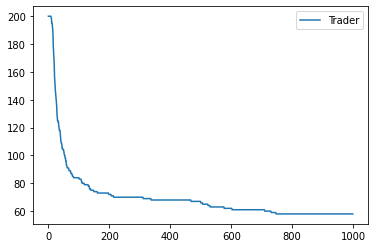

In [36]:
results.plot(y = "Trader", use_index=True)

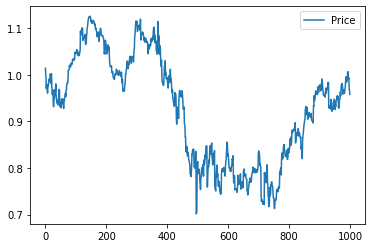

In [37]:
# plot
#part 2a
results.plot(y = "Price", use_index=True)

<BarContainer object of 1000 artists>

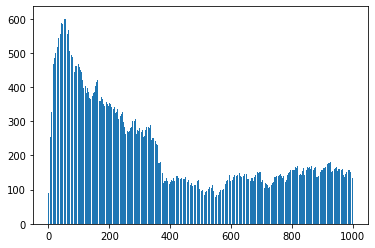

In [38]:
#part 2b

plt.bar(results.index, results["Trade volume"])